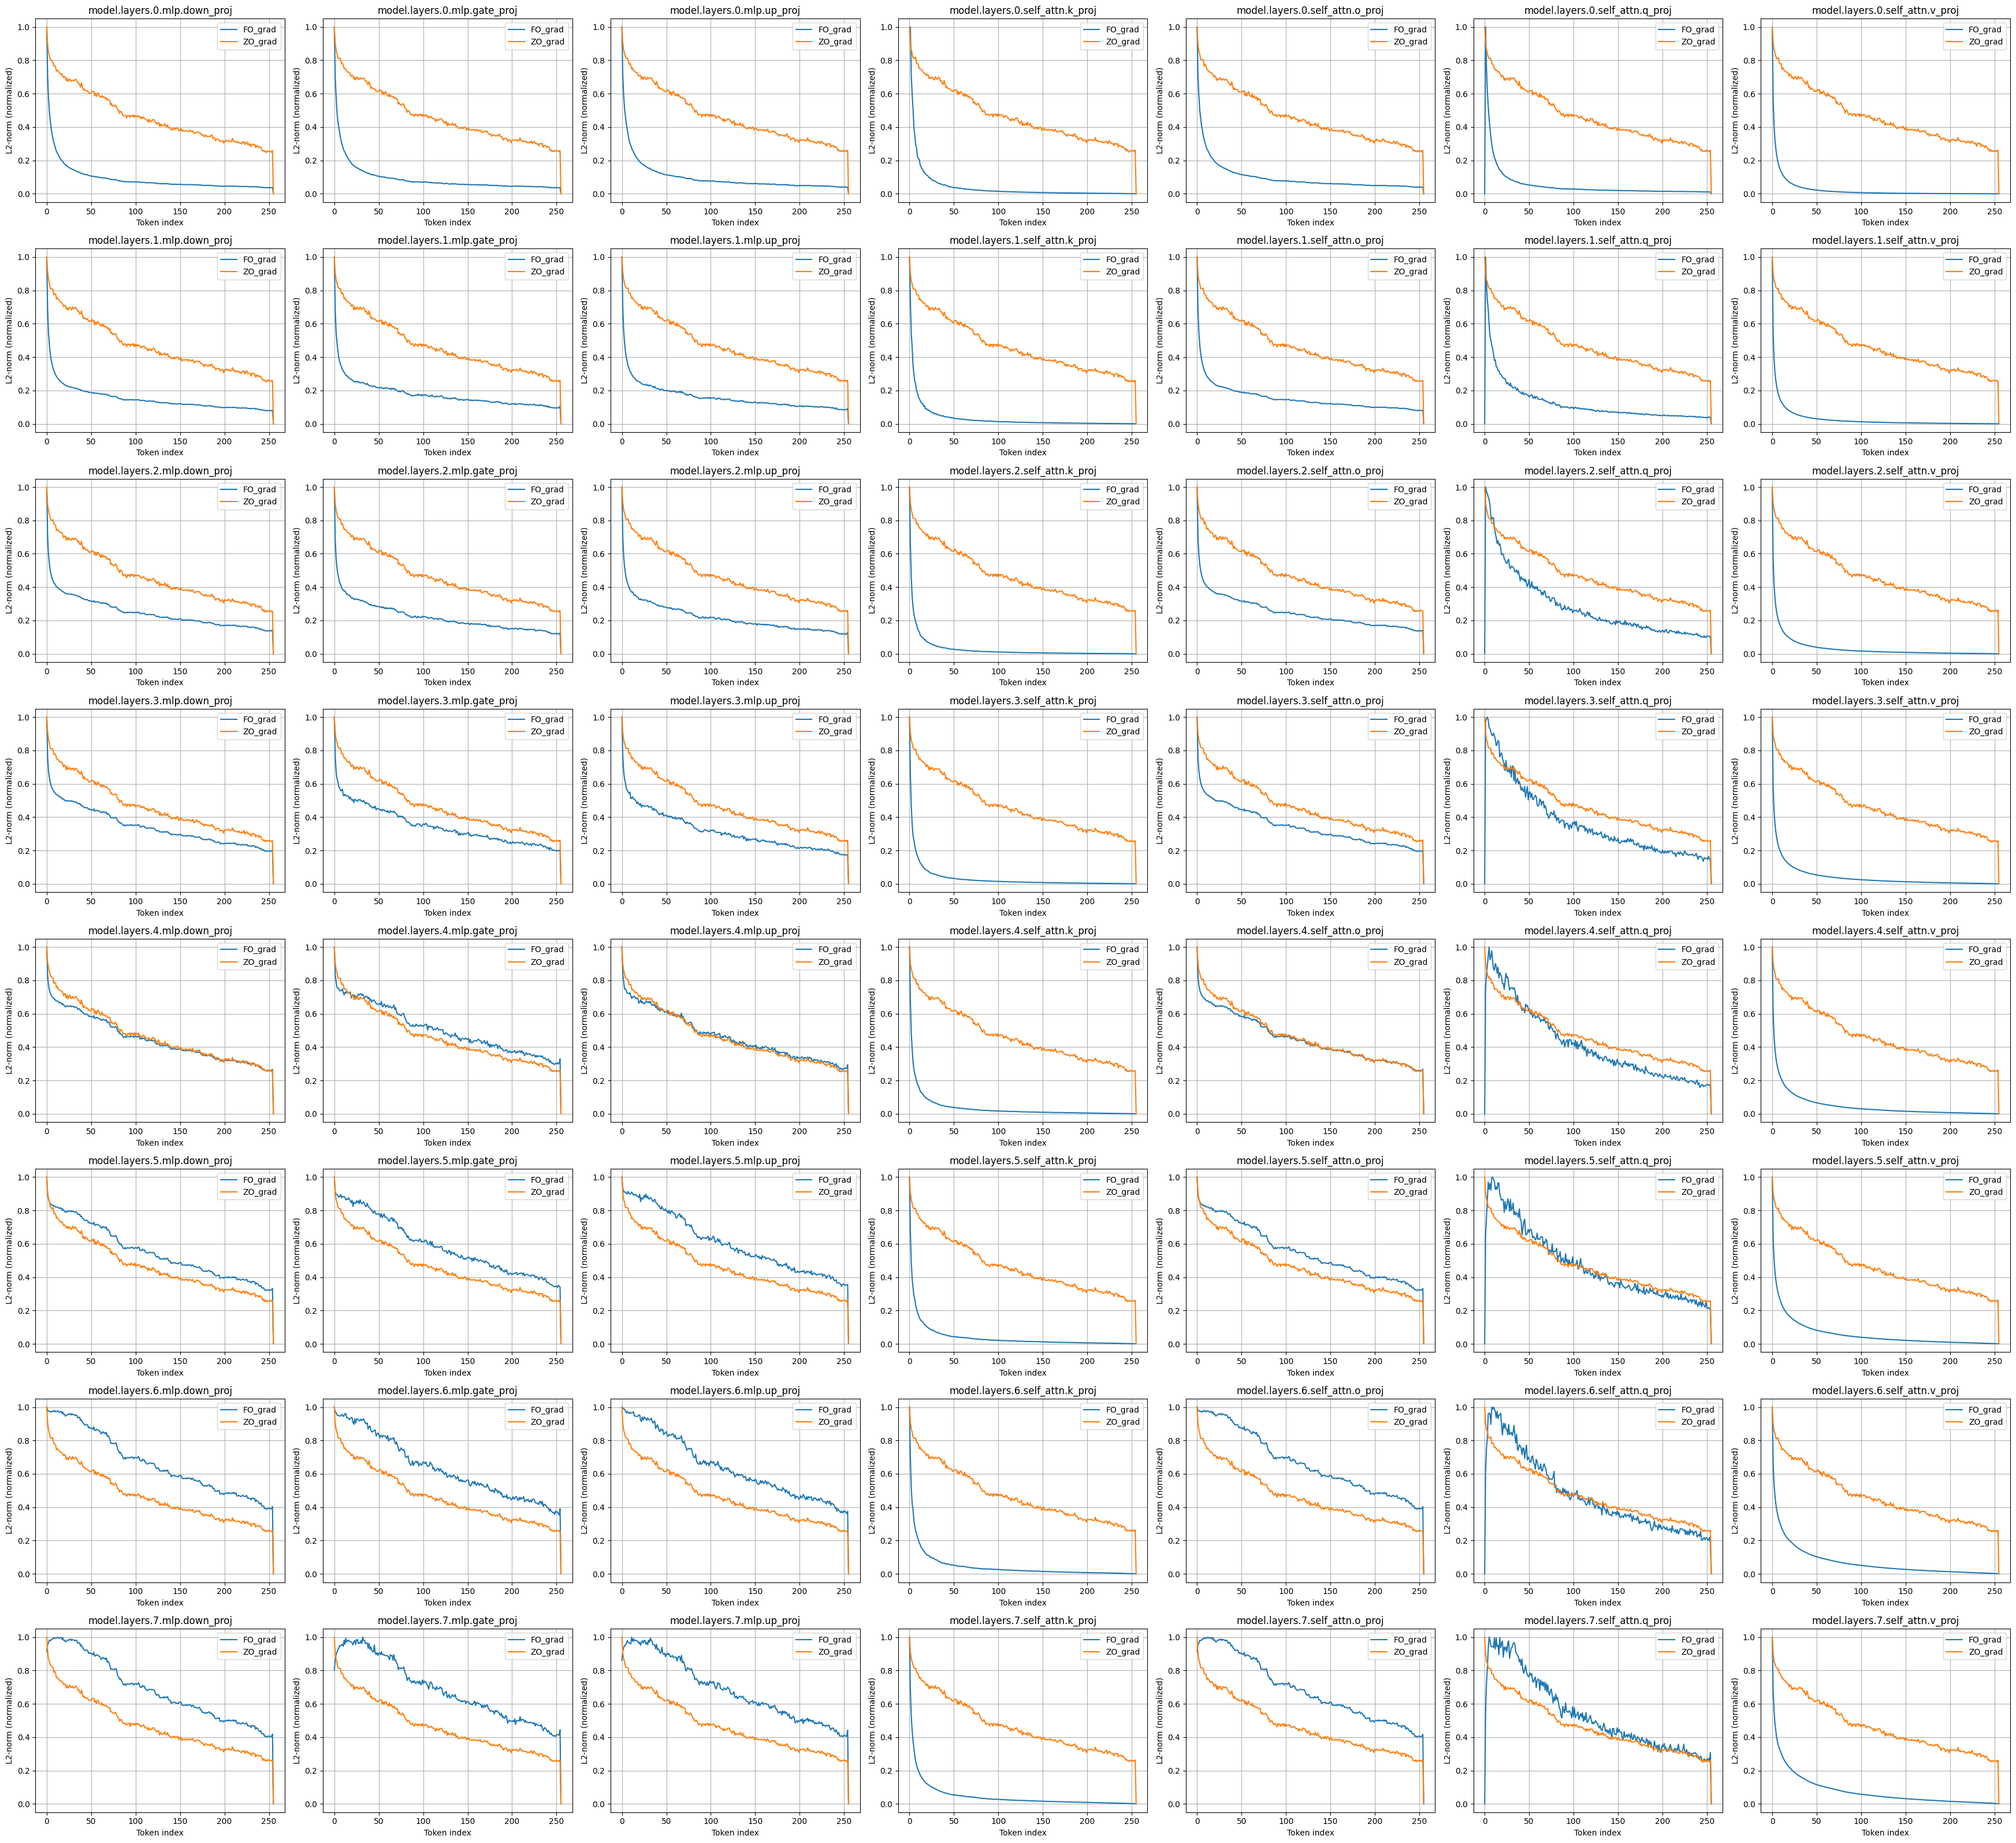

In [5]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_pt_folder(
    folder_path,
    value_key_list='output',
    scale_curves=False,
    average_batch=True
):
    """
    Plot token‑wise norms for all .pt files in a folder.
    Can plot one or more curves per subplot by passing a list of keys.
    Optionally min‑max normalizes each curve so they share the same [0,1] range,
    and can choose to average over the batch or use only the first sample.

    Args:
        folder_path (str): Path to folder containing .pt files.
        value_key_list (str or List[str]):
            - If a string, plots just that key.
            - If a list of strings, plots all listed keys with legend.
        scale_curves (bool): If True and multiple keys, min‑max normalize each curve.
        average_batch (bool): If True (default), average norms over the batch dimension.
                              If False, use only the first sample (index 0).
    """
    # normalize to list
    if isinstance(value_key_list, str):
        keys = [value_key_list]
    else:
        keys = value_key_list

    pt_files = sorted(f for f in os.listdir(folder_path) if f.endswith('.pt'))
    n = len(pt_files)
    if n == 0:
        raise ValueError(f"No .pt files found in {folder_path!r}")

    cols = min(7, n)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows), squeeze=False)
    axes = axes.flatten()

    for ax, fname in zip(axes, pt_files):
        data = torch.load(os.path.join(folder_path, fname), map_location='cpu')
        title = data.get('name', fname)

        # collect all curves first if we need to scale
        curves = {}
        for key in keys:
            # special combined key
            if key == 'ZO_FO':
                tensor = data['ZO_grad'] - data['FO_grad']
            else:
                if key not in data:
                    raise KeyError(f"Key {key!r} not found in {fname}; available: {list(data.keys())}")
                tensor = data[key]
            if not isinstance(tensor, torch.Tensor):
                tensor = torch.tensor(tensor)

            # [B, T, H] → norms [B, T]
            norms = tensor.norm(p=2, dim=-1).float().cpu().numpy()  # shape (batch, seq_len)

            # either average across batch or take only first sample
            if average_batch:
                curves[key] = norms.mean(axis=0)
            else:
                curves[key] = norms[0]

        # optional per‐curve [0,1] normalization
        if scale_curves and len(keys) > 1:
            for key in keys:
                arr = curves[key]
                mn, mx = arr.min(), arr.max()
                if mx > mn:
                    curves[key] = (arr - mn) / (mx - mn)
                else:
                    curves[key] = np.zeros_like(arr)

        # plot each
        for key in keys:
            ax.plot(np.arange(len(curves[key])), curves[key], label=key)

        ax.set_title(title)
        ax.set_xlabel('Token index')
        ylabel = 'L2‑norm'
        if not average_batch:
            ylabel += ' (first sample)'
        if scale_curves and len(keys) > 1:
            ylabel += ' (normalized)'
        ax.set_ylabel(ylabel)
        if len(keys) > 1:
            ax.legend(loc='upper right')
        ax.grid(True)

    # turn off any unused axes
    for ax in axes[n:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    dir_path = '/workspace/test/100/1179685/0'
    # average_batch: averaging over batch, or only first-sample ZO_grad without averaging
    plot_pt_folder(
        dir_path,
        value_key_list=['FO_grad', 'ZO_grad'],
        scale_curves=True,
        average_batch=True
    )


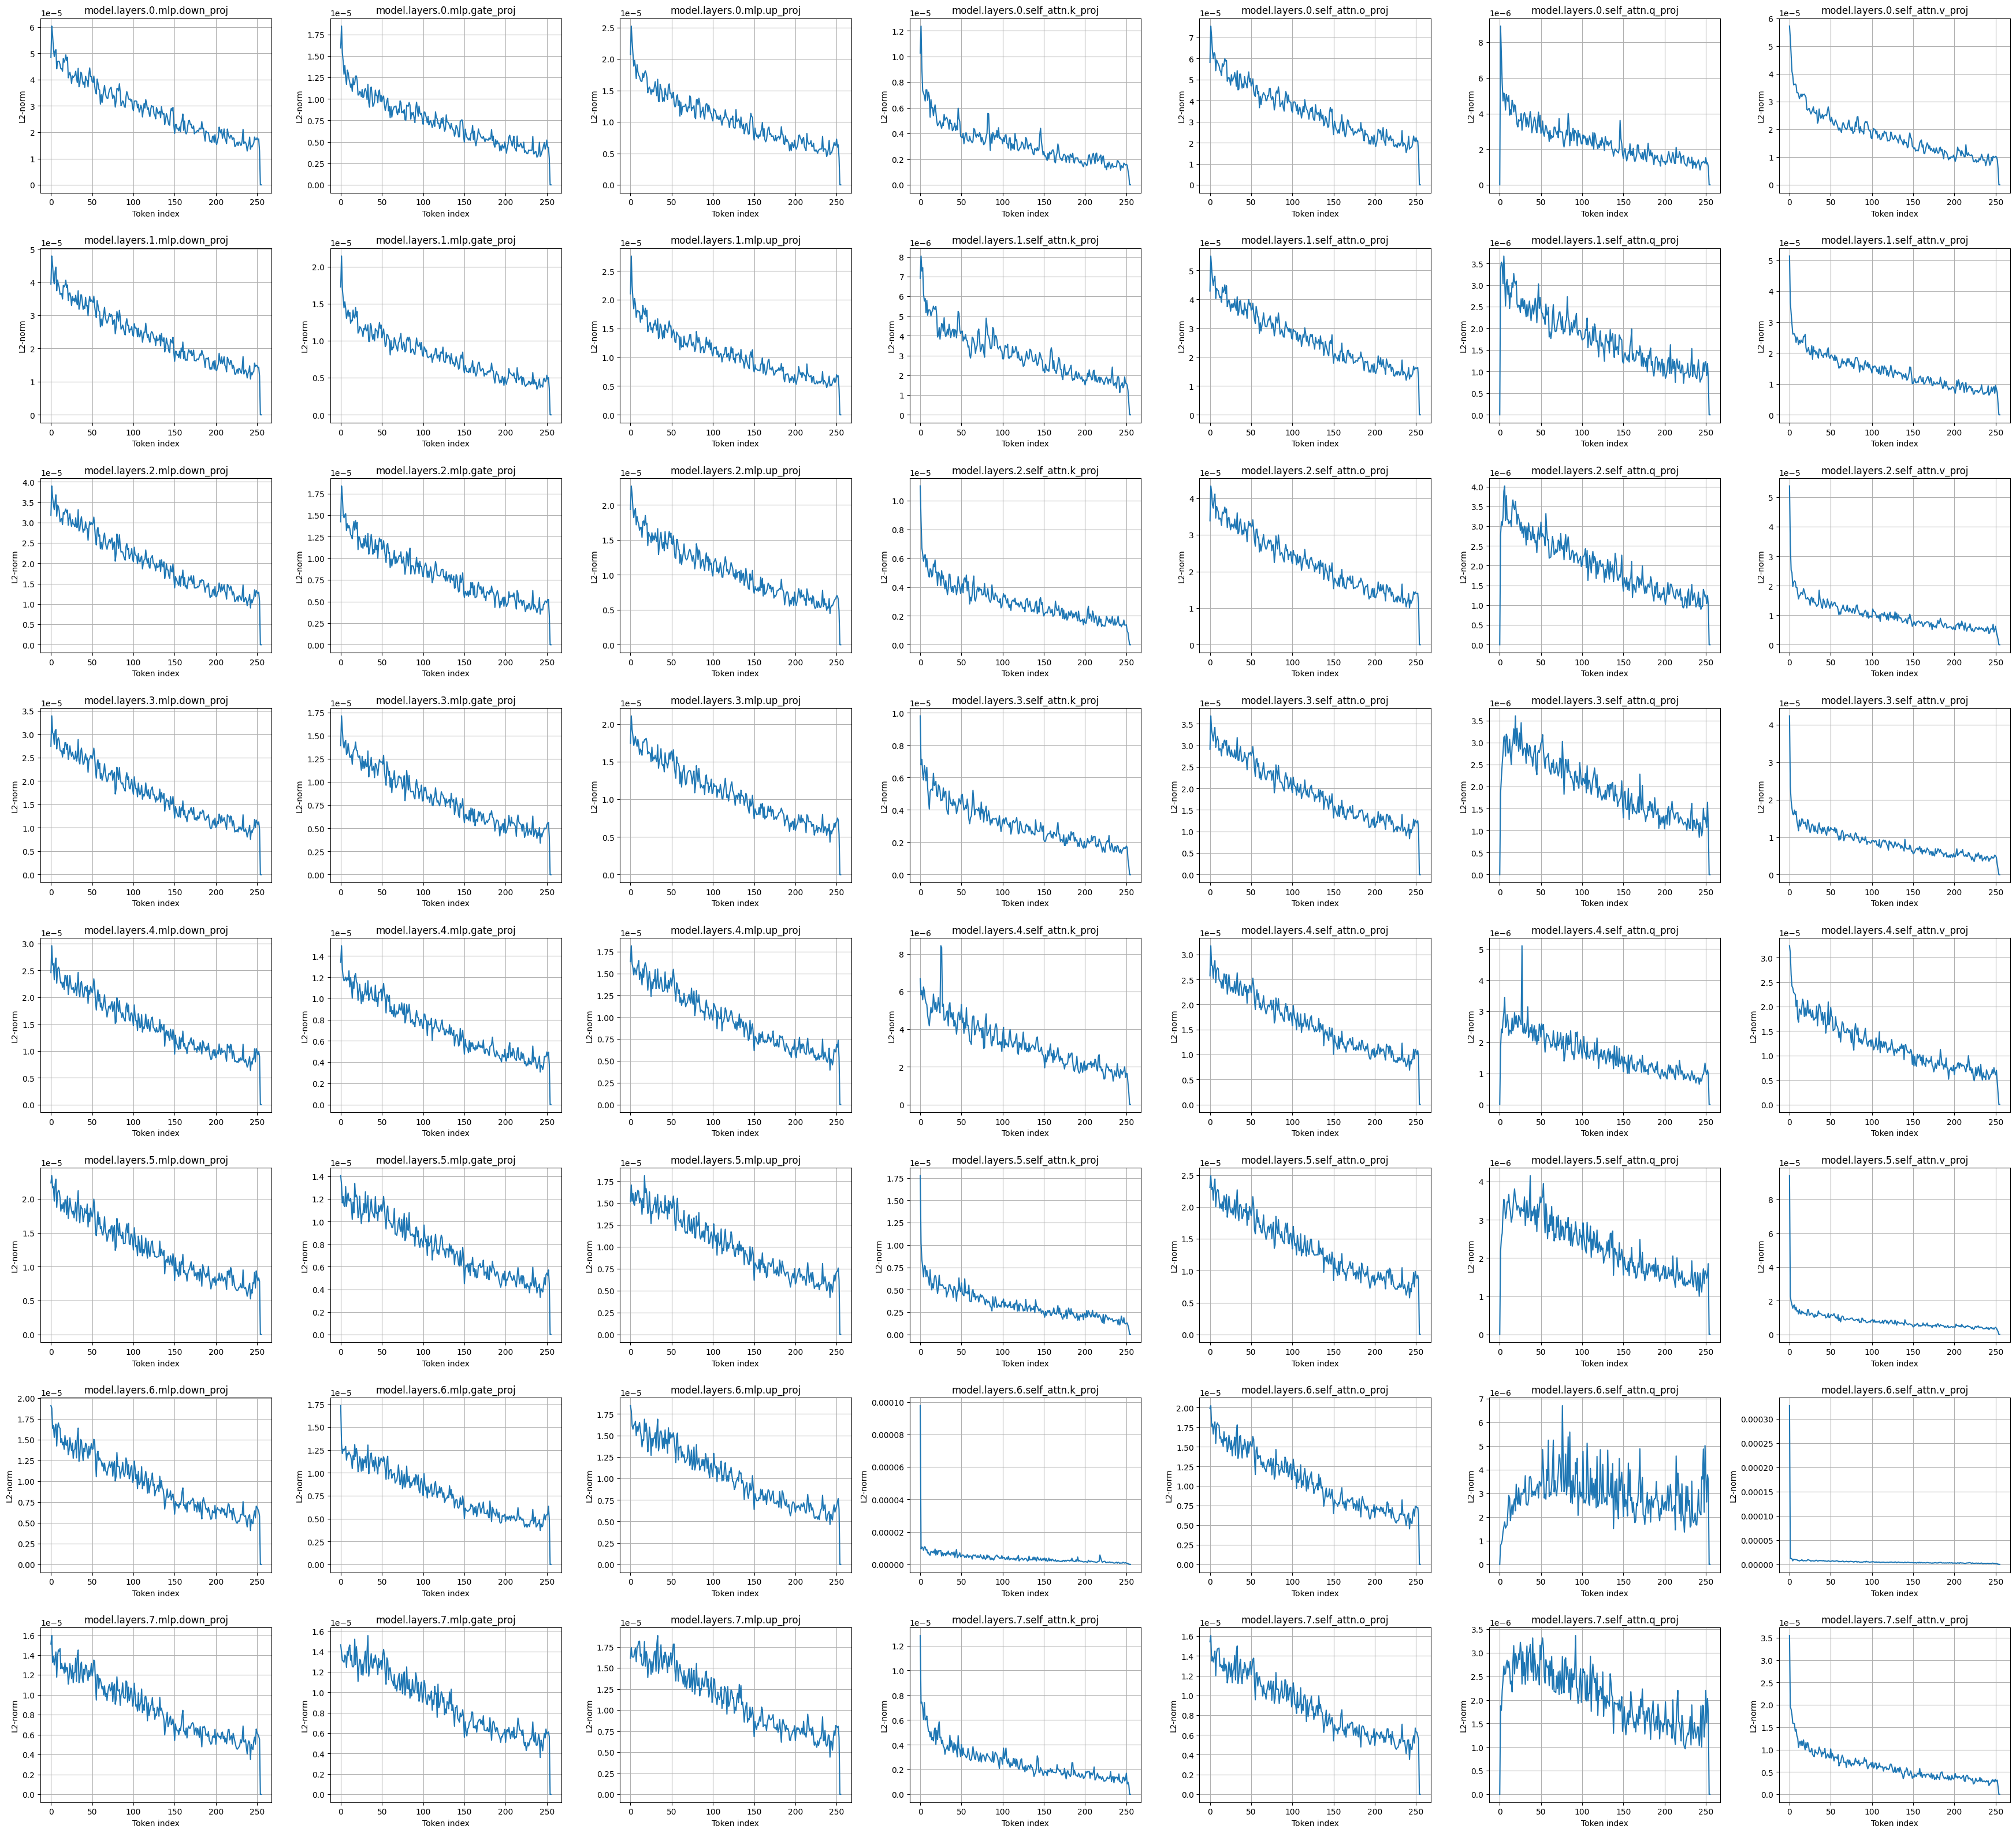

In [6]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_pt_folder(
    folder_path,
    value_key_list='output',
    scale_curves=False,
    average_batch=True,
    x_axis='token'        # new: 'token' or 'hidden'
):
    """
    Plot L2‑norms of tensors in .pt files, with flexible x‑axis.

    Args:
        folder_path (str): Path to folder containing .pt files.
        value_key_list (str or List[str]): key(s) to plot.
        scale_curves (bool): min‑max normalize curves per file.
        average_batch (bool): average across batch if True, else take sample 0.
        x_axis (str): which dim to use for x‑axis:
            - 'token' (default): x = token index (norm over hidden dim)
            - 'hidden'         : x = hidden index (norm over token dim)
    """
    # validate x_axis
    if x_axis not in ('token', 'hidden'):
        raise ValueError("x_axis must be 'token' or 'hidden'")

    # normalize to list
    keys = [value_key_list] if isinstance(value_key_list, str) else value_key_list

    pt_files = sorted(f for f in os.listdir(folder_path) if f.endswith('.pt'))
    if not pt_files:
        raise ValueError(f"No .pt files found in {folder_path!r}")

    n = len(pt_files)
    cols = min(7, n)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows), squeeze=False)
    axes = axes.flatten()

    for ax, fname in zip(axes, pt_files):
        path = os.path.join(folder_path, fname)
        data = torch.load(path, map_location='cpu')
        title = data.get('name', fname)

        curves = {}
        for key in keys:
            # support custom key
            if key == 'ZO_FO':
                tensor = data['ZO_grad'] - data['FO_grad']
            else:
                if key not in data:
                    raise KeyError(f"Key {key!r} not in {fname}")
                tensor = data[key]
            tensor = tensor if isinstance(tensor, torch.Tensor) else torch.tensor(tensor)

            # choose norm axis
            if x_axis == 'token':
                # collapse hidden_dim → per‑token norms
                norms = tensor.norm(p=2, dim=-1).float().cpu().numpy()   # shape (B, T)
            else:
                # collapse token_dim → per‑hidden norms
                norms = tensor.norm(p=2, dim=1).float().cpu().numpy()    # shape (B, H)

            # average or first
            if average_batch:
                curves[key] = norms.mean(axis=0)
            else:
                curves[key] = norms[0]

        # optional normalization
        if scale_curves and len(keys) > 1:
            for key in keys:
                arr = curves[key]
                mn, mx = arr.min(), arr.max()
                curves[key] = (arr - mn)/(mx - mn) if mx>mn else np.zeros_like(arr)

        # plot
        for key in keys:
            ax.plot(np.arange(len(curves[key])), curves[key], label=key)

        ax.set_title(title)
        ax.set_xlabel('Token index' if x_axis=='token' else 'Hidden-dim index')
        ylabel = 'L2‑norm'
        if not average_batch:
            ylabel += ' (first sample)'
        if scale_curves and len(keys)>1:
            ylabel += ' (normalized)'
        ax.set_ylabel(ylabel)
        if len(keys) > 1:
            ax.legend(loc='upper right', fontsize=12)
        ax.grid(True)

    # turn off unused axes
    for ax in axes[n:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

dir_path = '/workspace/test/100/1179685/30000'
# dir_path = '/workspace/test/1000/1283702/2000'

# Example: plot per-token norms (default)
plot_pt_folder(
    dir_path,
    value_key_list=['FO_grad'],
    scale_curves=False,
    average_batch=True,
    x_axis='token'     ### 'hidden'
)
